In [1]:
from fastai.vision.all import *
import torchvision
path=Path("/kaggle/input/celebrity-face-image-dataset/Celebrity Faces Dataset")
files=get_image_files(path)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(get_image_files(path/l)) for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same
    
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, parent_label, splits)
tls = TfmdLists(files, tfm, splits=splits)

def halftone(img):
    if isinstance(img, PILImage):
        img1=img.convert("1").convert("L")
        return img1
    else:
        return img

dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],
                     bs=4) # CUDA out of memory
#*aug_transforms()
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    def forward(self, x1, x2):
        x1 = self.encoder(x1)
        x2 = self.encoder(x2)
        x1 = self.head(x1)
        x2 = self.head(x2)
        return x1, x2

In [3]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    def forward(self, x1, x2):
        x1 = self.encoder(x1)
        x2 = self.encoder(x2)
        x1 = self.head(x1)
        x2 = self.head(x2)
        return x1, x2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = create_body(efficientnet_b3(pretrained=True), cut=-2)
head = create_head(1536, 128, [512, 256], 0.5, bn_final=True)
model = SiameseModel(encoder, head)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth
100%|██████████| 47.2M/47.2M [00:01<00:00, 28.3MB/s]


In [4]:
from fastai.optimizer import Adam
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, ops, target, size_average=True):
        op1, op2 = ops[0], ops[1]
        dist = F.pairwise_distance(op1, op2)
        pdist = dist * target
        ndist = dist * (~target)
        loss = 0.5 * ((pdist**2) + (F.relu(self.margin - ndist)**2))
        loss = loss.mean() if size_average else loss.sum()
        return loss

def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]
           

def contrastive_accuracy(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold).float()
    return (preds == targets).float().mean()

def accuracy(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    true_negatives = torch.sum((preds == 0) & (targets == 0)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives) if (true_positives + true_negatives + false_positives + false_negatives) > 0 else 0.0

    return accuracy

def precision(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0

    return precision

def recall(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    return recall

def f1_score(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return f1_score

class OptimalThreshold:
    def __init__(self, start=0.1, end=4.0, step=0.01):
        self.start = start
        self.end = end
        self.step = step
        self.best_threshold = None

    def find(self, preds, targets):
        best_accuracy = 0.0
        for threshold in np.arange(self.start, self.end, self.step):
            preds_thresholded = (preds < threshold).float()
            accuracy = (preds_thresholded == targets).float().mean()
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                self.best_threshold = threshold
                
class PrintBestThreshold(Callback):
    def after_epoch(self):
        print(f"Epoch {self.learn.epoch} LR:{self.opt.hypers[0]['lr']:.10f} Best threshold: {optimal_threshold.best_threshold:.2f}")

optimal_threshold = OptimalThreshold()

learn = Learner(dls, model, loss_func=ContrastiveLoss(margin=5.0), opt_func=Adam,
                splitter=siamese_splitter, metrics=[accuracy, precision, recall, f1_score],cbs=PrintBestThreshold())

In [5]:
pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38070 sha256=fafff87a5be7488404693d6b8a7fe6287ae50a82b72551589281460b5d0497f6
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam
Note: you may need to restart the kernel to use updated packages.


In [6]:
model_name="/kaggle/input/effnet-weights/efficientnet_b3_nx.pth"

In [7]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    def forward(self, x1, x2):
        x1 = self.encoder(x1)
        x2 = self.encoder(x2)
        x1 = self.head(x1)
        x2 = self.head(x2)
        return x1, x2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = create_body(efficientnet_b3(pretrained=True), cut=-2)
head = create_head(1536, 128, [512, 256], 0.5, bn_final=True)
model = SiameseModel(encoder, head)

In [8]:
!ls -sh /kaggle/input/effnet-weights/efficientnet_b3_nx.pth

144M /kaggle/input/effnet-weights/efficientnet_b3_nx.pth


In [9]:
learn = learn.load('/kaggle/input/effnet-weights/efficientnet_b3_nx')
encoder = learn.model.encoder

In [10]:
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM
def get_image_from_path(img_path):
    '''
    输入图像文件路径，输出 图像array、归一化图像array、预处理后的tensor
    '''
    img = np.array(Image.open(img_path).convert('RGB'))
    img = cv2.resize(img, (224, 224))
    rgb_img_float = np.float32(img) / 255
    input_tensor = preprocess_image(rgb_img_float,
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    return img, rgb_img_float, input_tensor
class EFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.feature_extractor = self.model[0]

    def __call__(self, x):
        return self.feature_extractor(x)[:, :, 0, 0]
    
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)

In [11]:
os.makedirs('/kaggle/working/save')

In [12]:
for i in range(1,17,2):
    img1_name=f"/kaggle/input/test-no-expand/nx/{i:03d}.jpg"
    img2_name=f"/kaggle/input/test-no-expand/nx/{i+1:03d}.jpg"
    car_img, car_img_float, car_tensor=get_image_from_path(img1_name)
    cloud_img, cloud_img_float, cloud_tensor =get_image_from_path(img2_name)
    extractor=EFeatureExtractor(encoder)
    car_concept_features = extractor(car_tensor)[0, :]
    cloud_concept_features = extractor(cloud_tensor)[0, :]
    
    target_layers = [encoder[0][-1]]
    car_targets = [SimilarityToConceptTarget(car_concept_features)]
    cloud_targets = [SimilarityToConceptTarget(cloud_concept_features)]
    # cloud on car
    with GradCAM(model=extractor,
                 target_layers=target_layers) as cam:
        car_grayscale_cam = cam(input_tensor=car_tensor,
                            targets=cloud_targets)[0, :]
    car_cam_image = show_cam_on_image(car_img_float, car_grayscale_cam, use_rgb=True,image_weight=0.7)
    Image.fromarray(car_cam_image).save(f"/kaggle/working/save/{i // 2}_0_cam.png")
    
    # car on cloud
    with GradCAM(model=extractor,
                 target_layers=target_layers) as cam:
        cloud_grayscale_cam = cam(input_tensor=cloud_tensor,
                            targets=car_targets)[0, :]
    cloud_cam_image = show_cam_on_image(cloud_img_float, cloud_grayscale_cam, use_rgb=True,image_weight=0.7)
    Image.fromarray(cloud_cam_image).save(f"/kaggle/working/save/{i // 2}_1_cam.png")

In [13]:
import zipfile
import os
 
def compress_folder(folder_path, output_path):
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arc_name = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arc_name)
 
# 使用示例
compress_folder('/kaggle/working/save', 'effnet_vcs_cam.zip')

In [14]:
img1_name=f"/kaggle/input/test-no-expand/nx/001.jpg"
img2_name=f"/kaggle/input/test-no-expand/nx/002.jpg"

In [15]:
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM
def get_image_from_path(img_path):
    '''
    输入图像文件路径，输出 图像array、归一化图像array、预处理后的tensor
    '''
    img = np.array(Image.open(img_path).convert('RGB'))
    img = cv2.resize(img, (224, 224))
    rgb_img_float = np.float32(img) / 255
    input_tensor = preprocess_image(rgb_img_float,
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    return img, rgb_img_float, input_tensor
class EFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.feature_extractor = self.model[0]
                
    def __call__(self, x):
        return self.feature_extractor(x)[:, :, 0, 0]
car_img, car_img_float, car_tensor=get_image_from_path(img1_name)
cloud_img, cloud_img_float, cloud_tensor =get_image_from_path(img2_name)
extractor=EFeatureExtractor(encoder)
car_concept_features = extractor(car_tensor)[0, :]
cloud_concept_features = extractor(cloud_tensor)[0, :]

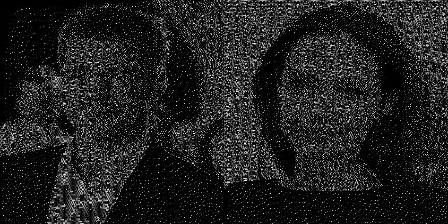

In [16]:
Image.fromarray(np.hstack((cloud_img, car_img)))

In [17]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)
    
target_layers = [encoder[0][-1]]
car_targets = [SimilarityToConceptTarget(car_concept_features)]
cloud_targets = [SimilarityToConceptTarget(cloud_concept_features)]

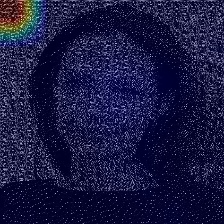

In [18]:
# self
with GradCAM(model=extractor,
             target_layers=target_layers) as cam:
    car_grayscale_cam = cam(input_tensor=car_tensor,
                        targets=car_targets)[0, :]
car_cam_image = show_cam_on_image(car_img_float, car_grayscale_cam, use_rgb=True,image_weight=0.7)
Image.fromarray(car_cam_image)

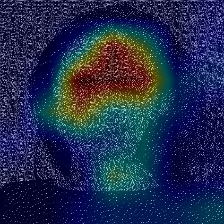

In [19]:
# cloud on car
with GradCAM(model=extractor,
             target_layers=target_layers) as cam:
    car_grayscale_cam = cam(input_tensor=car_tensor,
                        targets=cloud_targets)[0, :]
car_cam_image = show_cam_on_image(car_img_float, car_grayscale_cam, use_rgb=True,image_weight=0.7)
Image.fromarray(car_cam_image)


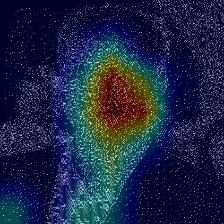

In [20]:
# car on cloud
with GradCAM(model=extractor,
             target_layers=target_layers) as cam:
    cloud_grayscale_cam = cam(input_tensor=cloud_tensor,
                        targets=car_targets)[0, :]
cloud_cam_image = show_cam_on_image(cloud_img_float, cloud_grayscale_cam, use_rgb=True,image_weight=0.7)
Image.fromarray(cloud_cam_image)

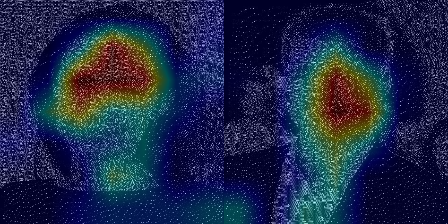

In [21]:
Image.fromarray(np.hstack((Image.fromarray(car_cam_image), Image.fromarray(cloud_cam_image))))

！！以上为修复代码！！